## Soft Actor-Critic

### Value Iteration

In [1]:
import jax.numpy as jnp
import jax.random as jrandom

import jax

from src.systems.linear import StochasticDoubleIntegrator
from src.RL.PolicyGradient.SoftActorCritic.main import *

import numpy as np
import matplotlib.pyplot as plt


In [2]:
key = jrandom.PRNGKey(0)
buffer_size = 1000

# Init environment
x0 = jnp.array([2, 0])
SDI = StochasticDoubleIntegrator(x0)
SAC = SoftActorCritic(2, 1, key, buffer_size=buffer_size)

# Set learning rates
SAC.SVF.eta = 1e-1
SAC.SQF_1.eta = 1e-1
SAC.SQF_2.eta = 1e-1
SAC.PI.eta = 1e-1

Nx = 10
x_space = np.linspace(-5, 5, Nx)
v_space = np.linspace(-5, 5, Nx)
u_space = np.linspace(-4, 4, 10)

def cost_to_normalized_reward(x):
    x = x/4.1
    return -min(x, 1)

for x in x_space:
    for v in v_space:
        state = jnp.array([x, v])
        for u in u_space:
            cost = SDI.cost(state, u)
            key, _ = jrandom.split(key)
            new_state = SDI.get_state_update(key, state, u)
            SAC.ReplayBuffer.store((state, u, cost_to_normalized_reward(cost), new_state))
            


In [4]:
key = jrandom.PRNGKey(0)
SAC.train(key, batch_size=50, n_epochs=50, show=True)
#cost_to_normalized_reward(0)


epoch=0 	 loss v=0.028 	 loss q1=0.129 	 loss q2=0.134 	 loss pi=-1.277
epoch=1 	 loss v=0.038 	 loss q1=0.129 	 loss q2=0.177 	 loss pi=-1.292
epoch=2 	 loss v=0.033 	 loss q1=0.080 	 loss q2=0.097 	 loss pi=-1.317
epoch=3 	 loss v=0.026 	 loss q1=0.082 	 loss q2=0.129 	 loss pi=-1.292
epoch=4 	 loss v=0.037 	 loss q1=0.087 	 loss q2=0.126 	 loss pi=-1.341
epoch=5 	 loss v=0.035 	 loss q1=0.085 	 loss q2=0.106 	 loss pi=-1.391
epoch=6 	 loss v=0.038 	 loss q1=0.097 	 loss q2=0.119 	 loss pi=-1.410
epoch=7 	 loss v=0.041 	 loss q1=0.065 	 loss q2=0.075 	 loss pi=-1.409
epoch=8 	 loss v=0.046 	 loss q1=0.070 	 loss q2=0.076 	 loss pi=-1.459
epoch=9 	 loss v=0.053 	 loss q1=0.080 	 loss q2=0.108 	 loss pi=-1.529
epoch=10 	 loss v=0.050 	 loss q1=0.089 	 loss q2=0.113 	 loss pi=-1.522
epoch=11 	 loss v=0.043 	 loss q1=0.068 	 loss q2=0.101 	 loss pi=-1.502
epoch=12 	 loss v=0.038 	 loss q1=0.069 	 loss q2=0.085 	 loss pi=-1.475
epoch=13 	 loss v=0.062 	 loss q1=0.079 	 loss q2=0.102 	 los

In [8]:
# key = jrandom.PRNGKey(0)
# for i in range(20):
#     SAC.train(key, batch_size=20, n_epochs=2, show=False)
#     print(SAC.PI.model.mu_layer.weight)

max(SAC.ReplayBuffer.data_points[:,3])



DeviceArray(-0.01234568, dtype=float32)

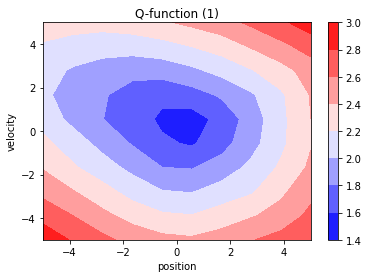

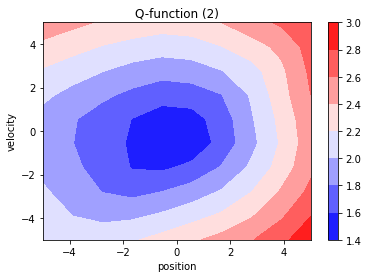

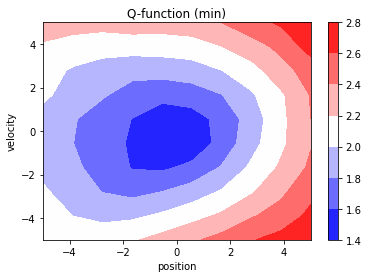

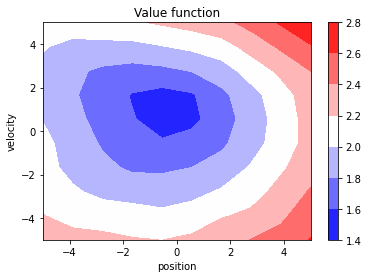

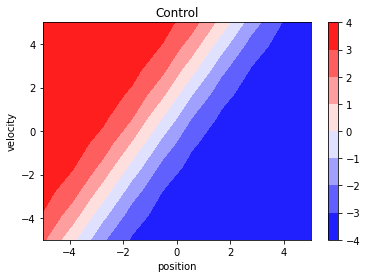

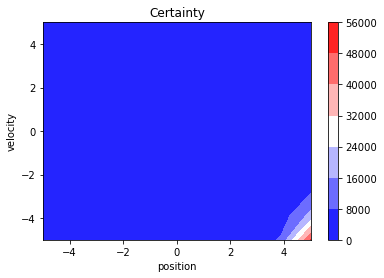

In [5]:
from matplotlib import cm
n=10
x = np.linspace(-5,5,n)
y = np.linspace(-5,5,n)
xv, yv = np.meshgrid(x,y)
zv = np.zeros((n, n))
zq = np.zeros((n, n))
zq1 = np.zeros((n,n))
zq2 = np.zeros((n,n))
zu = np.zeros((n, n))
zp = np.zeros((n, n))

Nu = 20
u_space = np.linspace(-1, 1, Nu)
Q = np.zeros(((n,n,Nu)))

for i in range(n):
    for j in range(n):
        for k in range(Nu):
            u = u_space[k]
            q1_val = SAC.SQF_1.predict(jnp.array([xv[i,j], yv[i,j]]), u)
            q2_val = SAC.SQF_2.predict(jnp.array([xv[i,j], yv[i,j]]), u)
            Q[i,j,k] = min(q1_val, q2_val)
        v_val = SAC.SVF.predict(jnp.array([xv[i,j], yv[i,j]]))
        q1_val = SAC.SQF_1.predict(jnp.array([xv[i,j], yv[i,j]]), 0)
        q2_val = SAC.SQF_2.predict(jnp.array([xv[i,j], yv[i,j]]), 0)
        q_val = min(q1_val, q2_val)
        u_val, log_prob = SAC.PI.get_control(jnp.array([xv[i,j], yv[i,j]]), key, deterministic=True)
        #_, u_val = SAC.get_control(jnp.array([xv[i,j], yv[i,j]]))
        zv[i,j] = v_val
        zu[i,j] = u_val
        zp[i,j] = log_prob
        zq[i,j] = q_val
        zq1[i,j] = q1_val
        zq2[i,j] = q2_val

plt.contourf(xv, yv, zq1, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function (1)')
plt.show()

plt.contourf(xv, yv, zq2, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function (2)')
plt.show()

plt.contourf(xv, yv, zq, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Q-function (min)')
plt.show()

plt.contourf(xv, yv, zv, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Value function')
plt.show()

plt.contourf(xv, yv, zu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Control')
plt.show()

plt.contourf(xv, yv, zp, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('Certainty')
plt.show()



TypeError: Shapes of x (10, 10) and z (10, 20) do not match

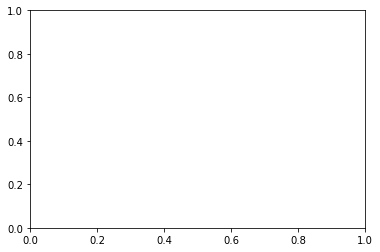

In [10]:
plt.contourf(xv, yv, Q[-1,:,:], cmap=cm.bwr)
plt.xlabel('velocity')
plt.ylabel('control')
plt.colorbar()
plt.title('Q-value at p=-5')
plt.show()

print(yv.shape)

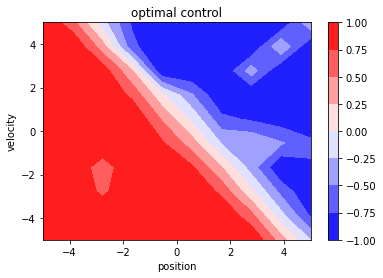

In [11]:
Q_idx = np.argmax(Q, axis=2)
Qu = np.zeros_like(Q_idx, dtype=np.float32)
for i, row in enumerate(Q_idx):
    for j, item in enumerate(row):
        Qu[i,j] = u_space[item]

plt.contourf(xv, yv, Qu, cmap=cm.bwr)
plt.xlabel('position')
plt.ylabel('velocity')
plt.colorbar()
plt.title('optimal control')
plt.show()